In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
)

In [61]:
# Read the datasets
fake_data = pd.read_csv("Fake.csv")
true_data = pd.read_csv("True.csv")

In [62]:
# Preprocess text (removing special characters, extra spaces)
def clean_text(text):
    text = text.str.replace(r"[^\w\s]", "", regex=True)  # Remove special characters
    text = text.str.lower()  # Convert to lowercase
    text = text.str.strip()  # Remove leading/trailing spaces
    return text

fake_data["text"] = clean_text(fake_data["text"])
true_data["text"] = clean_text(true_data["text"])

In [63]:
# Add labels to the datasets: 1 for fake, 0 for real
fake_data["label"] = 1
true_data["label"] = 0

In [64]:
# Combine datasets
data = pd.concat([fake_data, true_data], axis=0).reset_index(drop=True)

In [65]:
# Shuffle the dataset to mix fake and real samples
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [66]:
# Check for missing values
data.dropna(subset=["text"], inplace=True)

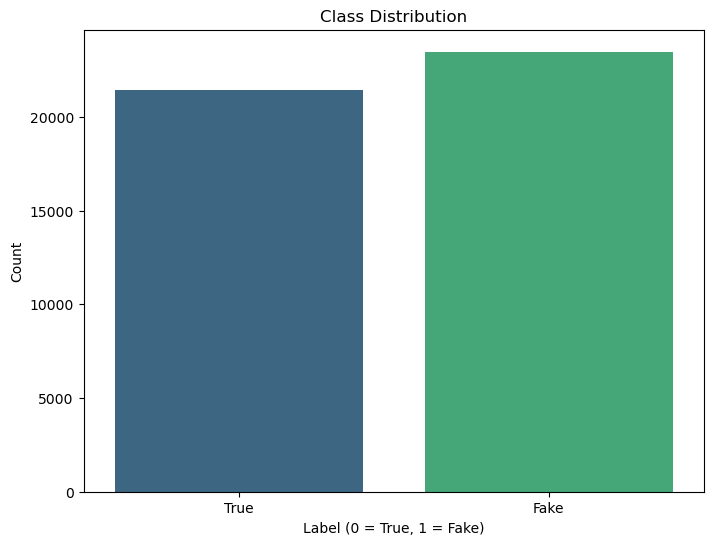

In [67]:
# **Visualization 1: Class Distribution**
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data, palette="viridis")  # Specify `x` and `data` as keyword arguments
plt.title("Class Distribution")
plt.xlabel("Label (0 = True, 1 = Fake)")
plt.ylabel("Count")
plt.xticks([0, 1], ["True", "Fake"])
plt.show()

In [68]:
# Add text length as a feature
data["text_length"] = data["text"].str.split().apply(len)

C:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


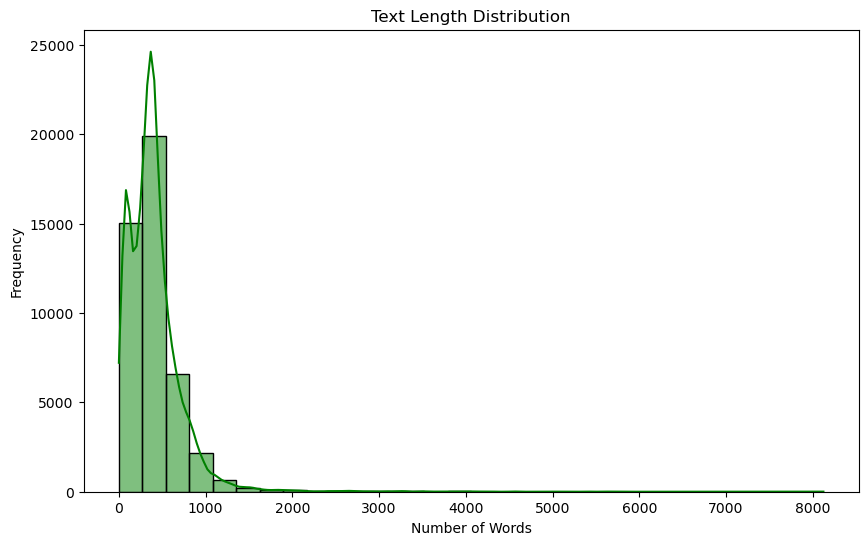

In [69]:
# **Visualization 2: Text Length Distribution**
plt.figure(figsize=(10, 6))
sns.histplot(x="text_length", data=data, kde=True, bins=30, color="green")  # Specify `x` and `data` as keyword arguments
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [70]:
# Use 'text' and 'label' columns
X, y = data["text"], data["label"]

In [71]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [72]:
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [73]:
# Initialize models
models = {
    "LinearSVC": LinearSVC(random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

Training LinearSVC...
LinearSVC Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4284
           1       1.00      0.99      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



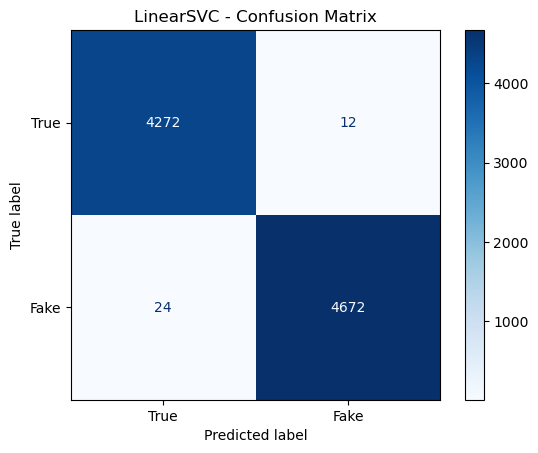

Training Naive Bayes...
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4284
           1       0.96      0.94      0.95      4696

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



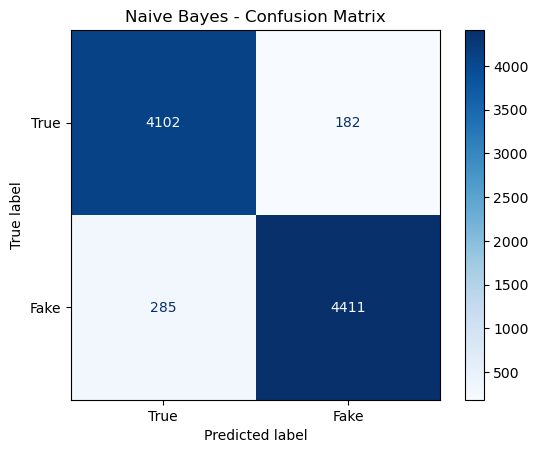

Training Logistic Regression...
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



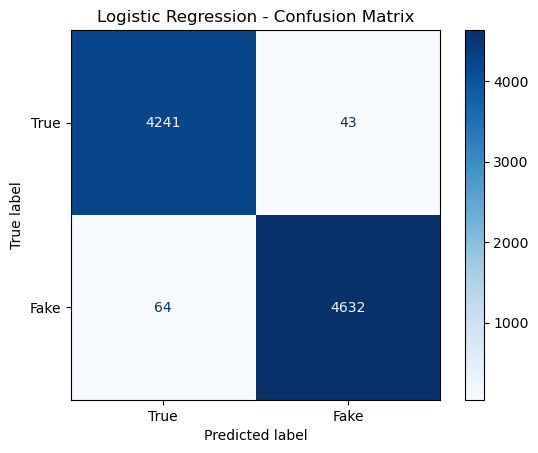

In [74]:
# Train and evaluate each model
metrics = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_vectorized, y_train)
    predictions = model.predict(X_test_vectorized)
    
    # Collect metrics for comparison
    report = classification_report(y_test, predictions, output_dict=True)
    metrics.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision (Fake)": report["1"]["precision"],
        "Recall (Fake)": report["1"]["recall"],
        "F1-score (Fake)": report["1"]["f1-score"]
    })
    
    # Print classification report and confusion matrix
    print(f"{model_name} Classification Report:\n{classification_report(y_test, predictions)}")
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "Fake"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

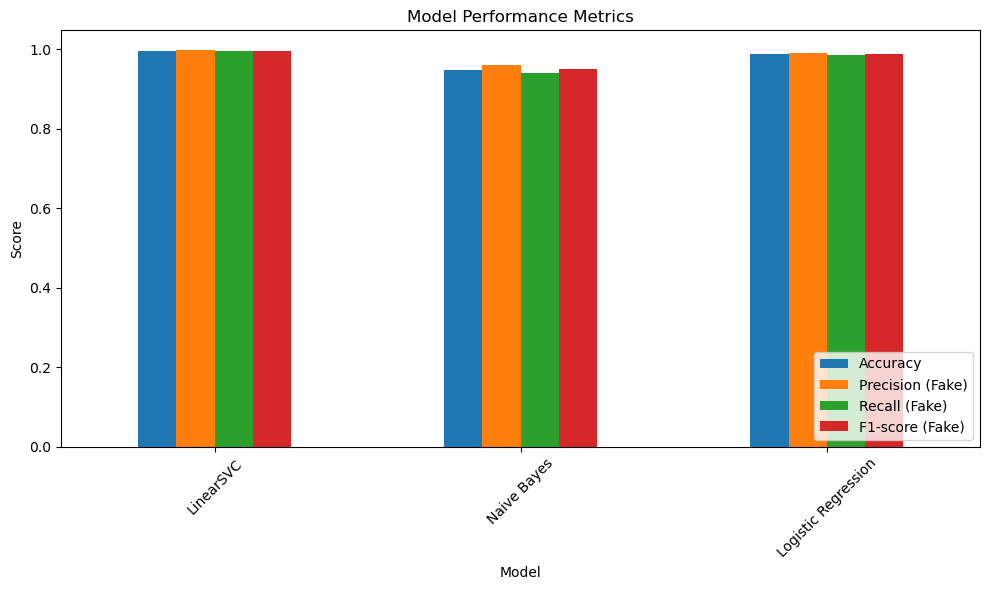

In [75]:
# **Visualization 3: Model Performance Comparison**
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc="lower right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

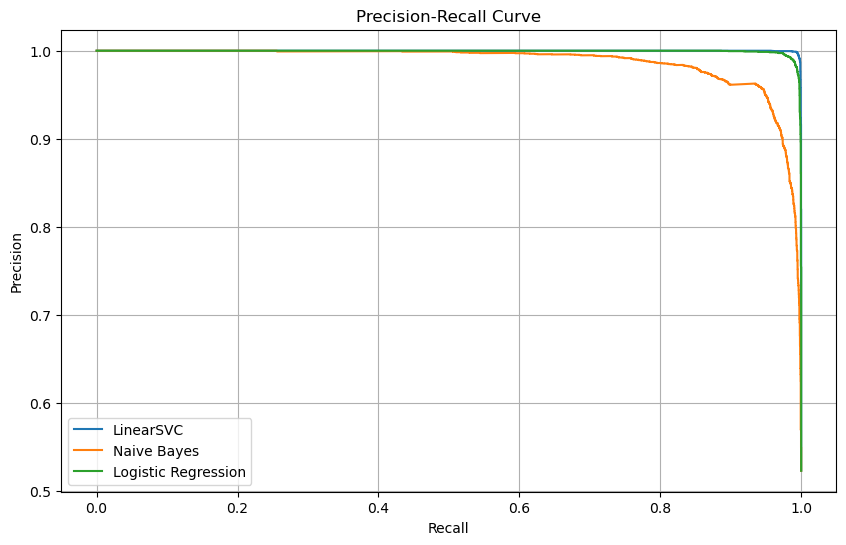

In [76]:
# **Visualization 4: Precision-Recall Curve**
plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    y_prob = model.decision_function(X_test_vectorized) if hasattr(model, "decision_function") else model.predict_proba(X_test_vectorized)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=model_name)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [77]:
# Test the models on new text
def predict_new_text(file_path, vectorizer, models):
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()
    
    # Clean and vectorize the text
    cleaned_text = clean_text(pd.Series(text))
    vectorized_text = vectorizer.transform(cleaned_text)
    
    for model_name, model in models.items():
        prediction = model.predict(vectorized_text)
        print(f"{model_name} Prediction: {'FAKE' if prediction[0] == 1 else 'REAL'}")

In [78]:
# Test new input
predict_new_text("mytest.txt", vectorizer, models)

LinearSVC Prediction: REAL
Naive Bayes Prediction: REAL
Logistic Regression Prediction: REAL


Training LinearSVC...
LinearSVC saved as linearsvc.pkl.
LinearSVC Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4284
           1       1.00      0.99      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



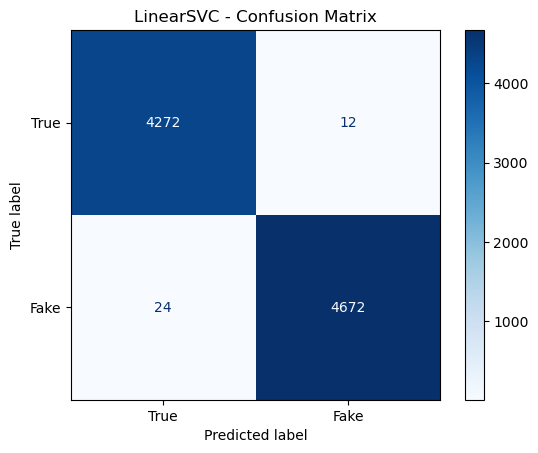

Training Naive Bayes...
Naive Bayes saved as naive_bayes.pkl.
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4284
           1       0.96      0.94      0.95      4696

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



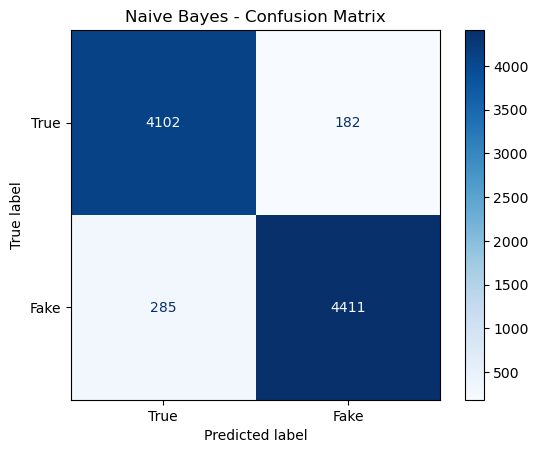

Training Logistic Regression...
Logistic Regression saved as logistic_regression.pkl.
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



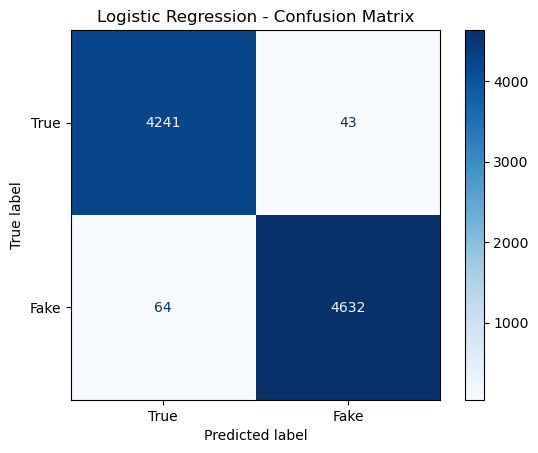

In [79]:
# Train and save models
import joblib

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_vectorized, y_train)
    
    # Save the trained model
    model_file = f"{model_name.lower().replace(' ', '_')}.pkl"
    joblib.dump((vectorizer, model), model_file)
    print(f"{model_name} saved as {model_file}.")
    
    # Evaluate the model
    predictions = model.predict(X_test_vectorized)
    print(f"{model_name} Classification Report:\n{classification_report(y_test, predictions)}")
    
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "Fake"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()